# Basic MRI Reconstruction

Many texts exist that go into far more detail than these, please see selected references at the end. The point of these notebooks is to demonstrate the various reconstructions and give users an opportunity to play with the various factors used in MR image reconstruction.

## Fourier Transforms

MRI data is acquired by an antenna (a radio frequency coil) in the frequency domain.[1] To reconstruct an image from this data a Fourier transform is required. To get some understadning of how Fourier transforms work here are some examples with a standard colour image. Below shows an image of the moon and it's resulting 2D Fourier Transform:

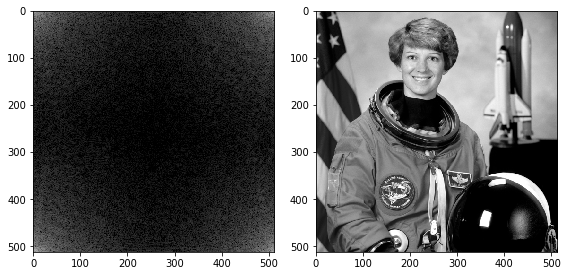

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn
from skimage import io, data
from skimage.color import rgb2gray
from matplotlib.colors import LogNorm

example_img = rgb2gray(data.astronaut())
example_img_fft = np.fft.fft2(example_img)
example_img_fft_abs = np.abs(example_img_fft)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(example_img_fft_abs,norm=LogNorm(vmin=5), cmap='gray')
ax[1].imshow(example_img, cmap='gray')

fig.tight_layout()
plt.show()

A simple example of the power of Fourier transforms is a simple high pass filter in the frequency domain. Here we can see that contrast information is contained in the edges of the frequency domain, as we mask out the rest of the frequency domain we detect the edges of the image.

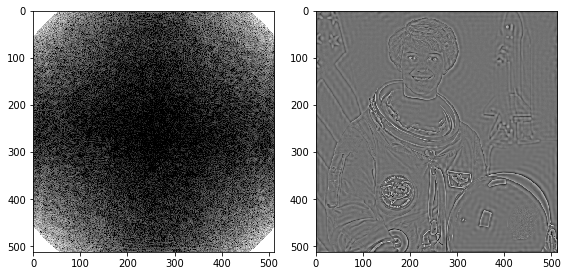

In [3]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

img_mask = create_circular_mask(512,512, radius=325)
example_img_masked = example_img_fft * img_mask
example_img_masked_ifft = np.fft.ifft2(example_img_masked).real

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(np.abs(example_img_masked),norm=LogNorm(vmin=5), cmap='gray')
ax[1].imshow(example_img_masked_ifft, cmap='gray')

fig.tight_layout()
plt.show()

Another simple example is a low pass filter in the frequency domain. Here we can see that contrast information is contained in the edges of the frequency domain, as we mask out the centre of the frequency domain we keep the contrast information but lose tyhe sharpness and the image becomes blurry.

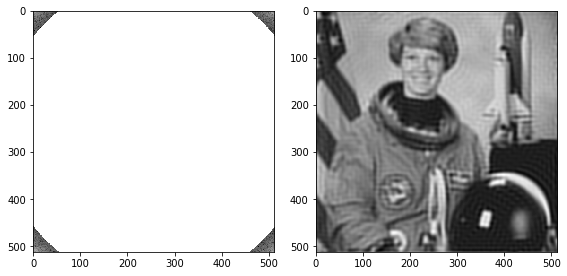

In [4]:
def create_circular_invmask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center >= radius
    return mask

img_mask2 = create_circular_invmask(512,512, radius=325)
example_img_masked2 = example_img_fft * img_mask2
example_img_masked_ifft = np.fft.ifft2(example_img_masked2).real

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(np.abs(example_img_masked2),norm=LogNorm(vmin=5), cmap='gray')
ax[1].imshow(example_img_masked_ifft, cmap='gray')

fig.tight_layout()
plt.show()

## 2D Reconstruction

The simplest MR image is a single two dimensional slice. Phase and frequency encoding are used to localise 2D voxels in the plane your are imaging. 

### Cartesian k-space

This is the simplest method of traversing k-space. We acquire a sinlge line of k-space at a time:

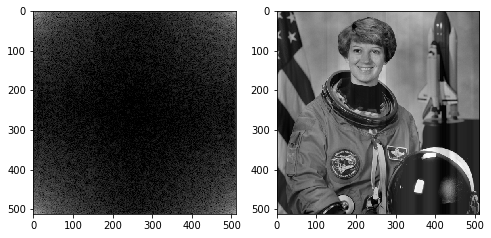

In [47]:
from matplotlib import animation, rc
from IPython.display import HTML

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

im1 = ax1.imshow(np.zeros((512,512)), cmap='gray')
im2 = ax2.imshow(np.zeros((512,512)), cmap='gray')

def line_mask(x, y, inc):
    mask = np.zeros((x, y))
    mask[:inc,:] = True
    mask[inc:,:] = False
    return mask

def run(i):
    example_img_fft = np.fft.fft2(example_img) * line_mask(512, 512, i)
    example_img_trunc = np.abs(np.fft.ifft2(example_img_fft))
    example_img_fft_abs = np.abs(example_img_fft)
    im1 = ax1.imshow(example_img_fft_abs, norm=LogNorm(vmin=5), cmap='gray')
    im2 = ax2.imshow(example_img_trunc, cmap='gray')
    return im1, im2,

anim = animation.FuncAnimation(fig, run, frames=range(1,512,51), blit=True)

rc('animation', html='jshtml')
anim

# References
[1] Moore, E. A., McRobbie, D., Prince, M. R., & Graves, M. J. (2006). MRI: From Picture to Proton (D. W. McRobbie (ed.); Second Ed). Cambridge University Press.
[2] 4.1.08, Jelly beans, taken from the USC-SIPI image database (Online, Accessed 6/5/2020) Available from: http://sipi.usc.edu/database/database.php?volume=misc&image=8#top